# Split the data form the multi rater setting

We have 100 images available with double annotations and 20 images (overlapping with the prevoius 100) with consesus annotations. We split the data as follows:
1. Train: 70 images sampled form the 100-20 images with double annotations
2. Validation: the remaining 10 images from above
3. Test: 20 images with consensus annotations

Regarding the train and validation splits, we create three versions:
1. Annotations of only annotator A
2. Annotations of only annotator B
3. Annotations from both annotators

In [11]:

import os
import sys
import shutil
sys.path.append(os.path.dirname(os.getcwd()))

from matplotlib import pyplot as plt
import numpy as np
import pandas  as pd
from sklearn.model_selection import train_test_split, StratifiedKFold


from src.utils.utils import *
from src.utils.const import *

random_state = 42

dataset_1 = "../dataset/Lucrezia_m"
dataset_2 = "../dataset/Ekin_m"
dataset_test = "../dataset/merge_together_corrected_m"

Remove the test images form the test dataset and associate to each image the number of detections

Number of images in dataset 1: 100
Number of images in dataset 2: 100
Number of images in test dataset: 20


/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_71714/2154137752.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nr_det_1, nr_det_2, nr_det_all, nr_det_test],


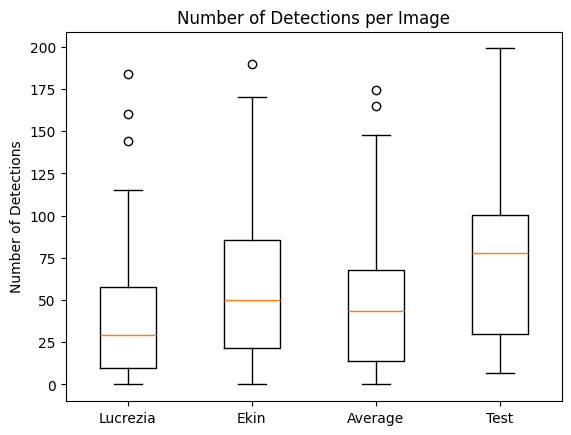

In [12]:
def get_detections_number(annotation_path):
    """
    Returns the number of detections in the annotation file.
    """
    if not os.path.exists(annotation_path):
        return 0
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
    return len(lines)-1

images_paths_1 = get_images_paths(dataset_1)
print(f"Number of images in dataset 1: {len(images_paths_1)}")
images_paths_2 = get_images_paths(dataset_2)
print(f"Number of images in dataset 2: {len(images_paths_2)}")
images_paths_test = get_images_paths(dataset_test)
print(f"Number of images in test dataset: {len(images_paths_test)}")
images_rel_paths_test = [os.path.relpath(path, dataset_test) for path in images_paths_test]

# remove test images from L and E datasets
images_paths_test_1 = [path for path in images_paths_1 if os.path.relpath(path, dataset_1) in images_rel_paths_test]
images_paths_1 = [path for path in images_paths_1 if os.path.relpath(path, dataset_1) not in images_rel_paths_test]
images_paths_test_2 = [path for path in images_paths_2 if os.path.relpath(path, dataset_2) in images_rel_paths_test]
images_paths_2 = [path for path in images_paths_2 if os.path.relpath(path, dataset_2) not in images_rel_paths_test]

images_rel_paths_train = [os.path.relpath(path, dataset_1) for path in images_paths_1]

annotations_paths_1 = get_annotations_paths(images_paths_1, dataset_1)
annotations_paths_test_1 = get_annotations_paths(images_paths_test_1, dataset_1)
annotations_paths_2 = get_annotations_paths(images_paths_2, dataset_2)
annotations_paths_test_2 = get_annotations_paths(images_paths_test_2, dataset_2)
annotations_paths_test = get_annotations_paths(images_paths_test, dataset_test)

# associate each image with the number of detections
nr_det_1 = [get_detections_number(path) for path in annotations_paths_1]
nr_det_2 = [get_detections_number(path) for path in annotations_paths_2]
nr_det_all = [(x + y)/2 for (x,y) in zip(nr_det_1, nr_det_2)]
nr_det_test = [get_detections_number(path) for path in annotations_paths_test]


plt.boxplot([nr_det_1, nr_det_2, nr_det_all, nr_det_test],
            labels=['Lucrezia', 'Ekin', 'Average', 'Test'])
plt.title('Number of Detections per Image')
plt.ylabel('Number of Detections')
plt.show()



Sprint train and validation set. It has to be the same for both annotators. The sampling is done keeping the # of detections distribution even among splits.

/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_71714/1816880873.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nr_det_all, y_train, y_val],


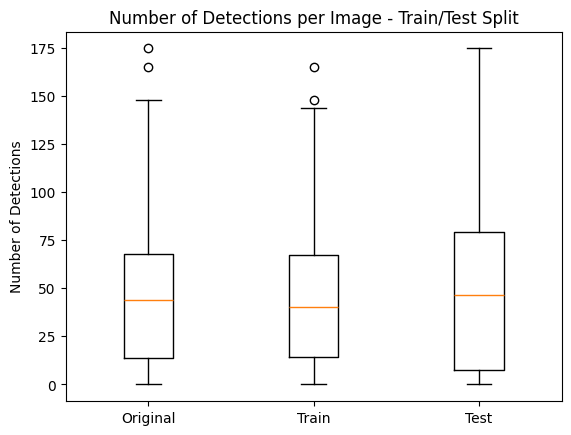

In [13]:
def bin(data: List, n_bins: int):
    """
    Bin the data into n_bins bins of similar size
    :param data: data to be binned
    :param n_bins: number of bins
    :return: binned data
    """
    data = np.array(data)
    # sort the data
    sorted_indices = data.argsort()
    bins = np.linspace(0, len(data), n_bins + 1)
    binned_data = np.digitize(sorted_indices, bins) - 1
    return binned_data


# define bins boundaries
bins = bin(nr_det_all, 4)
x_train, x_val, y_train, y_val = train_test_split(
    images_rel_paths_train, nr_det_all, test_size=0.2, random_state=random_state, stratify=bins
)

plt.boxplot([nr_det_all, y_train, y_val], 
            labels=['Original', 'Train', 'Test'])
plt.title('Number of Detections per Image - Train/Test Split')
plt.ylabel('Number of Detections')
plt.show()


Merge the two annotators dataset, by adding a label in the annotation file

In [ ]:
images_path_train_1 = [os.path.join(dataset_1, path) for path in x_train]
images_path_train_2 = [os.path.join(dataset_2, path) for path in x_train]
annotations_paths_train_1 = get_annotations_paths(images_path_train_1, dataset_1)
annotations_paths_train_2 = get_annotations_paths(images_path_train_2, dataset_2)

images_path_val_1 = [os.path.join(dataset_1, path) for path in x_val]
images_path_val_2 = [os.path.join(dataset_2, path) for path in x_val]
annotations_paths_val_1 = get_annotations_paths(images_path_val_1, dataset_1)
annotations_paths_val_2 = get_annotations_paths(images_path_val_2, dataset_2)

def create_dataset(images_paths, annotations_paths_1, annotations_paths_2, dataset_path):
    for image_path, annotation_path_1, annotation_path_2 in zip(images_paths, annotations_paths_1, annotations_paths_2):
        annotation_1 = pd.read_csv(annotation_path_1, sep=',', index_col=0)
        annotation_1["annotator"] = 1
        annotation_2 = pd.read_csv(annotation_path_2, sep=',', index_col=0)
        annotation_2["annotator"] = 2
        annotation = pd.concat([annotation_1, annotation_2], axis=0, ignore_index=True)
        # write the data
        new_image_path = os.path.join(dataset_path, os.path.relpath(image_path, dataset_1))
        new_annotation_path = os.path.join(dataset_path, os.path.relpath(annotation_path_1, dataset_1))
        os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
        shutil.copy(image_path, new_image_path)
        os.makedirs(os.path.dirname(new_annotation_path), exist_ok=True)
        annotation.to_csv(new_annotation_path, sep=',')

def create_dataset_all(images_paths, annotations_paths_1, annotations_paths_2, dataset_path):
    for image_path, annotation_path_1, annotation_path_2 in zip(images_paths, annotations_paths_1, annotations_paths_2):
        annotation_1 = pd.read_csv(annotation_path_1, sep=',', index_col=0)
        annotation_2 = pd.read_csv(annotation_path_2, sep=',', index_col=0)
        # write the data
        image_rel_dir = os.path.dirname(os.path.relpath(image_path, dataset_1))
        image_filename = os.path.basename(image_path)
        new_image_path_1 = os.path.join(dataset_path, image_rel_dir, f"{image_filename.split('.')[0]}_1.{image_filename.split('.')[1]}")
        new_image_path_2 = os.path.join(dataset_path, image_rel_dir, f"{image_filename.split('.')[0]}_2.{image_filename.split('.')[1]}")
        # annotation_filename = os.path.basename(annotation_path_1)
        # new_annotation_path_1 = os.path.join(dataset_path, os.path.dirname(os.path.relpath(annotation_path_1, dataset_1)), f"{annotation_filename.split('.')[0]}_1.{annotation_filename.split('.')[1]}")
        # new_annotation_path_2 = os.path.join(dataset_path, os.path.dirname(os.path.relpath(annotation_path_2, dataset_2)), f"{annotation_filename.split('.')[0]}_2.{annotation_filename.split('.')[1]}")
        new_annotation_path_1, new_annotation_path_2 = get_annotations_paths([new_image_path_1, new_image_path_2], dataset_path)
        os.makedirs(os.path.dirname(new_image_path_1), exist_ok=True)
        shutil.copy(image_path, new_image_path_1)
        os.makedirs(os.path.dirname(new_annotation_path_1), exist_ok=True)
        annotation_1.to_csv(new_annotation_path_1, sep=',')
        os.makedirs(os.path.dirname(new_image_path_2), exist_ok=True)
        shutil.copy(image_path, new_image_path_2)
        os.makedirs(os.path.dirname(new_annotation_path_2), exist_ok=True)
        annotation_2.to_csv(new_annotation_path_2, sep=',')

# train_dataset_path = "../dataset/train_multirater"
# os.makedirs(train_dataset_path, exist_ok=True)
# create_dataset(images_path_train_1, annotations_paths_train_1, annotations_paths_train_2, train_dataset_path)

# val_dataset_path = "../dataset/val_multirater"
# os.makedirs(val_dataset_path, exist_ok=True)
# create_dataset(images_path_val_1, annotations_paths_val_1, annotations_paths_val_2, val_dataset_path)   

# val_dataset_all_path = "../dataset/val_multirater_all"
# os.makedirs(val_dataset_all_path, exist_ok=True)
# create_dataset_all(images_path_val_1, annotations_paths_val_1, annotations_paths_val_2, val_dataset_all_path)

test_dataset_path = "../dataset/test_multirater"
os.makedirs(test_dataset_path, exist_ok=True)
print(images_paths_test_1)
print(annotations_paths_test_1)
print(annotations_paths_test_2)
create_dataset(images_paths_test_1, annotations_paths_test_1, annotations_paths_test_2, test_dataset_path)

['../dataset/Lucrezia_m/images/D223_CTRL_d9/Bortezomib/4x_XY291_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D223_CTRL_d9/DMSO/4x_XY36_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D223_CTRL_d9/DMSO/4x_XY287_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D223_CTRL_d9/Intermediate_response/4x_XY200_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D223_CTRL_d9/Intermediate_response/4x_XY194_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D223_CTRL_d9/Intermediate_response/4x_XY150_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/DMSO/4x_XY363_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/DMSO/4x_XY167_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/Intermediate_response/4x_XY47_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/Intermediate_response/4x_XY179_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/Intermediate_response/4x_XY108_Z001_CH4.tif', '../dataset/Lucrezia_m/images/D284_DMSO_d9/Intermediate_response/4x_XY75_Z001_CH4.tif', '../dataset/L

,x1,y1,x2,y2,mask,annotator
0,1447.000008,1033.999987,1507.999992,1093.000002,1986753 12 1903 21 1897 24 1892 31 1888 33 188...,1
1,320.999994,510.999999,375.000000,586.000013,979534 41 1877 44 1875 45 1874 46 1873 47 1872...,1
2,902.000027,112.999996,938.999977,160.000001,215941 31 1889 34 1886 35 1885 37 1883 37 1883...,1
3,100.999997,1183.000002,156.999993,1239.999990,2267636 30 1885 40 1878 44 1876 45 1874 48 187...,1
4,537.999973,1065.999985,593.999977,1119.000006,2045357 24 1888 35 1883 40 1879 43 1877 45 187...,1
5,1449.999962,1039.999981,1500.000000,1089.999962,1996342 30 1887 36 1882 39 1880 41 1877 45 187...,2
6,1305.999985,1021.999998,1360.999947,1071.999979,1961649 15 1900 23 1895 27 1891 31 1887 35 188...,2
7,1462.000008,1249.000025,1532.999954,1308.999968,2395703 56 1862 63 1857 64 1856 65 1855 66 185...,2
8,1204.000053,1348.999987,1302.000046,1422.000017,2589395 40 1877 45 1873 50 1868 54 1865 56 186...,2
9,712.000008,896.000032,780.000000,946.000013,1719129 52 1866 54 1865 55 1864 56 1863 57 186...,2


,x1,y1,x2,y2,mask,annotator
0,339.000006,535.000019,491.999989,711.999979,1021813 38 1878 48 1869 58 1861 61 1858 63 185...,1
1,585.999985,1107.000017,687.999973,1210.000019,2124143 30 1888 35 1883 38 1878 47 1871 51 186...,1
2,1018.000031,1271.999989,1110.000000,1373.999977,2439442 27 1888 40 1879 43 1876 45 1872 51 186...,1
3,1148.999977,1045.999975,1235.000038,1130.999994,2005655 37 1879 44 1874 47 1870 52 1867 55 186...,1
4,1543.000031,1252.999992,1629.999962,1340.999966,2403494 24 1891 34 1884 38 1880 43 1874 48 187...,1
...,...,...,...,...,...,...
188,192.000003,1359.999962,235.000005,1396.000013,2609491 18 1896 28 1890 32 1886 34 1884 36 188...,2
189,249.000006,1354.999981,294.999990,1396.000013,2599949 10 1903 22 1896 25 1893 29 1889 32 188...,2
190,1117.000008,960.000029,1144.000053,992.000027,1842400 23 1894 27 1893 27 1893 27 1893 27 189...,2
191,1720.999947,1164.000006,1762.999992,1204.000025,2234682 34 1885 37 1882 39 1881 40 1880 41 187...,2


,x1,y1,x2,y2,mask,annotator
0,1170.999985,20.000000,1307.999954,150.999999,35790 40 1874 51 1867 54 1865 57 1860 62 1854 ...,1
1,750.000000,108.000004,852.999973,208.000009,204310 25 1890 35 1883 39 1879 43 1874 49 1868...,1
2,1498.000031,926.000004,1583.999977,1013.999977,1775612 30 1888 35 1883 38 1879 43 1875 46 187...,1
3,1075.999947,922.000036,1174.000053,1024.000025,1767513 19 1891 37 1881 41 1877 45 1870 55 186...,1
4,376.999998,800.000038,487.000008,922.999964,1532579 31 1885 38 1880 41 1878 43 1872 52 186...,1
...,...,...,...,...,...,...
173,1489.000053,577.999992,1524.999962,621.999979,1109344 10 1904 20 1898 23 1897 24 1894 27 189...,2
174,895.000019,1121.000032,952.999992,1175.999994,2153218 25 1892 33 1887 35 1885 39 1881 42 187...,2
175,1615.999947,978.000011,1673.999977,1031.000032,1877486 22 1888 37 1880 41 1878 43 1873 47 187...,2
176,486.000023,182.999997,562.999992,248.999999,349935 67 1849 72 1846 75 1844 76 1844 76 1843...,2


,x1,y1,x2,y2,mask,annotator
0,1282.000008,1123.999987,1397.999954,1249.000025,2155566 34 1883 40 1879 43 1876 45 1872 49 186...,1
1,1358.999977,1218.000040,1474.000053,1336.999998,2336120 36 1878 46 1871 50 1869 52 1865 60 185...,1
2,470.000010,531.999979,551.999989,622.999992,1018105 25 1890 33 1885 37 1879 43 1875 46 187...,1
3,1112.999954,1068.000011,1225.999947,1172.000027,2047889 19 1889 40 1877 46 1872 49 1866 57 186...,1
4,169.999995,1114.000025,307.999992,1261.000013,2135260 36 1881 42 1876 45 1874 47 1869 55 186...,1
...,...,...,...,...,...,...
166,1340.000038,791.000004,1395.000000,838.000031,1518163 15 1900 29 1888 32 1887 34 1885 36 188...,2
167,122.999997,27.000001,233.000007,119.000001,50043 25 5 14 1876 67 1852 75 1845 80 1840 82 ...,2
168,82.000000,21.000000,154.999995,112.000004,38512 30 1882 41 1877 45 1874 48 1871 51 1868 ...,2
169,512.000027,1371.000023,554.000015,1408.000002,2630913 34 1885 38 1882 39 1880 40 1880 40 188...,2


,x1,y1,x2,y2,mask,annotator
0,1386.000023,1186.999969,1500.000000,1307.000027,2276626 35 1878 45 1873 49 1870 51 1866 59 186...,1
1,1410.999985,206.999996,1546.999969,341.999996,395060 37 1876 50 1867 56 1863 58 1861 61 1853...,1
2,642.999973,858.000040,749.000015,972.000017,1644204 41 1876 46 1873 47 1870 51 1865 57 186...,1
3,1029.999962,1057.000036,1114.000053,1143.999996,2026665 24 1891 32 1887 35 1882 41 1877 44 187...,1
4,1050.000000,1174.999981,1116.000023,1242.000017,2255159 16 1900 23 1891 33 1886 36 1882 40 187...,1
...,...,...,...,...,...,...
120,1640.000038,512.999983,1705.999947,589.000010,984684 62 1857 64 1855 65 1854 66 1854 66 1853...,2
121,1453.000031,515.000010,1486.999969,547.000008,988335 20 1899 23 1896 25 1895 26 1893 28 1892...,2
122,1590.000000,1090.999975,1633.000031,1133.000021,2094397 25 1890 34 1885 36 1883 39 1881 39 188...,2
123,502.999992,1265.999994,617.000027,1359.000034,2427418 74 1842 83 1836 85 1832 89 1829 91 182...,2


,x1,y1,x2,y2,mask,annotator
0,1022.999954,448.000016,1070.000038,499.999981,859277 18 1897 29 1889 35 1883 38 1881 41 1878...,1
1,1185.999985,757.999992,1242.000046,806.999960,1454625 48 1872 50 1869 52 1868 53 1867 54 186...,1
2,566.999989,952.000008,629.000015,1001.999989,1826513 18 1897 27 1890 32 1887 35 1882 39 187...,1
3,1184.000015,711.999979,1209.999962,737.999983,1368235 9 1906 15 1902 20 1898 23 1896 24 1896...,1
4,719.000015,917.999983,813.000011,1001.999989,1761379 45 1871 52 1866 54 1863 60 1859 62 185...,1
5,799.999981,1097.999983,940.000019,1243.999958,2103234 35 1878 48 1869 53 1865 56 1863 58 185...,1
6,1475.000038,1170.000000,1514.000015,1205.999966,2245958 30 1889 33 1887 34 1885 36 1884 37 188...,1
7,690.999985,1166.999960,750.999985,1219.999981,2239428 18 1897 31 1887 36 1883 38 1881 41 187...,1
8,724.999981,1378.000031,810.999985,1437.999973,2642675 25 1888 36 1881 41 1875 47 1872 48 186...,1
9,431.000004,993.999968,483.000011,1075.000019,1906999 31 1882 42 1877 46 1874 47 1873 50 187...,1


,x1,y1,x2,y2,mask,annotator
0,783.999996,1052.999983,847.000008,1111.999998,2020636 24 1895 27 1892 31 1888 34 1885 37 188...,1
1,742.999992,132.000003,813.000011,200.000010,252281 37 1880 42 1876 46 1873 48 1870 51 1868...,1
2,891.000023,1077.999973,951.000023,1143.999996,2068752 30 1887 34 1882 39 1879 43 1876 45 187...,1
3,1014.999962,614.000001,1059.999962,673.999987,1177989 17 1901 23 1895 26 1893 28 1891 30 188...,1
4,1275.999985,890.999966,1335.000000,943.999987,1712008 26 1892 33 1886 36 1882 40 1879 42 187...,1
...,...,...,...,...,...,...
142,1603.000031,225.999992,1687.999992,307.000000,433632 36 1877 51 1867 56 1861 60 1859 61 1858...,2
143,1078.000031,448.000016,1101.000023,471.999993,863164 11 1907 16 1903 19 1900 21 1898 22 1897...,2
144,1094.000015,402.000003,1152.000046,461.000018,771042 17 1877 11 7 27 1 9 1863 57 1863 57 186...,2
145,936.000023,150.999999,977.999954,190.000005,288959 1 1 3 1 1 1907 19 1897 25 1893 28 1890 ...,2


,x1,y1,x2,y2,mask,annotator
0,1480.999947,1207.999992,1561.999969,1291.999998,2317026 34 1884 38 1881 40 1877 45 1873 49 187...,1
1,948.000011,203.999999,1010.000038,264.000006,390724 28 1890 33 1885 37 1882 39 1880 42 1877...,1
2,745.000019,243.999996,821.000004,320.000002,467329 39 1878 48 1870 52 1866 54 1865 55 1863...,1
3,238.000002,431.000004,318.999996,509.999986,825851 48 1869 54 1864 58 1861 62 1857 64 1855...,1
4,331.999998,832.999964,395.000010,890.999966,1595866 18 1896 31 1888 35 1884 38 1881 41 187...,1
...,...,...,...,...,...,...
322,495.999985,937.999992,536.999989,976.999998,1799561 8 1908 15 1903 20 1897 23 1894 27 1891...,2
323,264.999990,1260.000000,305.999994,1314.999962,2417552 2 1 20 1894 33 1886 36 1883 39 1880 40...,2
324,286.000013,1338.000011,339.999990,1395.000000,2565410 31 1885 50 1870 53 1867 54 1865 55 186...,2
325,313.999987,1228.000002,346.999998,1291.999998,2358099 4 1911 11 1906 15 1903 18 1896 24 1896...,2


,x1,y1,x2,y2,mask,annotator
0,1450.999947,763.999987,1499.000015,813.000040,1466423 16 1900 24 1894 30 1889 32 1886 36 188...,1
1,1229.000015,993.000040,1266.000023,1033.999987,1905876 15 1902 22 1897 24 1895 26 1893 29 189...,1
2,1495.999947,1355.999994,1525.999947,1384.000025,2605022 14 1904 20 1900 21 1898 24 1895 26 189...,1
3,678.999996,32.000001,723.000011,72.000001,60214 21 1895 27 1891 31 1888 33 1885 37 1882 ...,1
4,183.999996,423.999996,227.999997,474.999990,812363 8 1908 16 1902 20 1899 23 1896 25 1894 ...,1
...,...,...,...,...,...,...
70,1255.999947,551.000018,1295.000038,586.999984,1057264 22 1893 31 1888 36 1883 37 1883 38 188...,2
71,596.999989,908.000021,636.000023,947.000027,1743967 12 1906 17 1902 20 1898 24 1895 26 189...,2
72,893.999977,755.000038,921.000023,774.000034,1450507 7 1908 15 1903 19 1900 22 1897 23 1895...,2
73,1279.000053,806.999960,1309.000053,831.000023,1550730 18 1900 21 1898 23 1896 24 1895 25 189...,2


,x1,y1,x2,y2,mask,annotator
0,1155.000000,689.999986,1222.000008,749.999971,1322133 11 1900 34 1884 39 1880 43 1876 45 187...,1
1,1199.000015,328.000002,1251.000023,383.000007,629050 11 1905 21 1897 27 1892 31 1888 36 1883...,1
2,1096.999969,548.999991,1165.999947,632.999997,1053280 26 1888 37 1880 41 1877 45 1874 47 187...,1
3,1236.000023,608.000007,1276.999969,653.000007,1166686 14 1903 21 1896 27 1892 30 1889 32 188...,1
4,1664.000015,394.999995,1722.000046,442.999992,758153 14 1902 34 1885 41 1878 45 1874 49 1870...,1
...,...,...,...,...,...,...
67,1387.999992,438.999982,1417.000008,467.000012,844281 9 1908 15 1903 18 1900 21 1899 22 1897 ...,2
68,1101.000023,786.000023,1129.000053,813.999968,1510232 17 1902 19 1899 21 1897 23 1896 24 189...,2
69,1378.000031,165.999995,1403.999977,193.999994,322027 8 1910 13 1906 15 1904 18 1901 20 1899 ...,2
70,1845.999985,173.000003,1900.999947,229.000010,335939 15 1 2 16 2 1882 41 1876 46 1872 39 6 3...,2


,x1,y1,x2,y2,mask,annotator
0,923.999977,1231.999969,985.999947,1287.000017,2366391 6 2 17 1879 43 1872 50 1869 51 1867 54...,1
1,1140.999985,211.000006,1201.999969,272.000005,404349 37 1881 41 1878 44 1876 46 1873 49 1871...,1
2,429.999990,1359.999962,495.000000,1431.999979,2609716 31 1887 36 1884 39 1880 42 1877 44 187...,1
3,647.000027,1062.000017,709.999981,1134.000034,2037793 36 1879 42 1874 47 1870 50 1869 51 186...,1
4,967.999992,6.000000,1020.999985,58.000002,10589 20 1895 32 1885 38 1880 41 1877 43 1876 ...,1
...,...,...,...,...,...,...
124,866.000004,1386.999979,918.999996,1437.999973,2665840 16 1900 23 1898 24 1896 26 1891 31 188...,2
125,1193.999977,88.000000,1246.999969,132.999995,168245 30 1884 48 1871 49 1871 49 1873 47 1872...,2
126,1215.000000,120.000004,1252.000008,156.000001,231638 4 1897 1 1 24 1894 32 1887 34 1886 34 1...,2
127,309.999990,293.999999,361.000013,338.000007,564805 14 1906 20 1897 27 1891 31 1888 33 1885...,2


,x1,y1,x2,y2,mask,annotator
0,1081.999969,245.000010,1127.999954,288.999996,469575 14 1902 24 1894 29 1889 33 1886 35 1883...,1
1,1171.999969,264.000006,1208.999977,304.999995,506146 15 1901 21 1897 25 1894 27 1891 29 1889...,1
2,1542.000046,1123.999987,1612.000008,1201.999998,2157730 2 1 21 1887 37 1874 49 1869 52 1867 54...,1
3,567.999973,1127.000027,619.999981,1179.000034,2162505 19 1897 26 1892 30 1889 32 1886 34 188...,1
4,1126.999969,567.999988,1168.000031,606.999993,1089770 24 1895 29 1890 32 1887 35 1885 36 188...,1
5,1052.999954,614.000001,1094.000015,650.000010,1178026 14 1903 21 1897 25 1894 28 1890 32 188...,1
6,975.999985,774.000034,1012.999992,814.999981,1485143 15 1902 23 1895 26 1893 28 1891 30 188...,1
7,941.000004,384.999990,987.000046,426.999993,738239 7 1 2 1903 24 1894 29 1889 33 1886 36 1...,1
8,817.999992,416.999989,850.000019,464.999986,799548 10 1907 17 1901 21 1898 23 1895 26 1893...,1
9,837.999973,865.999975,893.999977,929.999971,1661655 19 1899 25 1894 28 1890 31 1889 32 188...,1


,x1,y1,x2,y2,mask,annotator
0,91.999998,253.000009,132.000003,285.999999,483938 22 1896 27 1892 29 1890 32 1887 35 1885...,1
1,716.999989,238.999994,786.000023,312.000003,457698 25 1893 30 1890 32 1887 36 1883 38 1881...,1
2,1123.000031,994.999981,1152.000046,1029.000006,1909610 12 1906 16 1903 18 1901 20 1899 22 189...,1
3,273.999996,103.000002,343.000002,182.999997,196124 31 1886 37 1882 40 1879 43 1876 45 1875...,1
4,973.000031,51.000000,1014.999962,91.000003,96988 14 1902 23 1895 26 1892 30 1889 32 1887 ...,1
...,...,...,...,...,...,...
164,45.999999,54.000002,72.000003,72.000001,103733 4 1911 21 1899 23 1896 25 1895 25 1895 ...,2
165,37.000000,68.999999,65.000002,91.000003,134455 5 1905 17 1903 19 1899 23 1896 24 1894 ...,2
166,98.999999,120.999995,124.999995,141.999997,234355 4 1907 16 1903 19 1900 20 1899 22 1896 ...,2
167,175.000005,135.000000,230.999994,172.000000,257476 19 1897 30 1887 36 1882 41 1877 46 1872...,2


,x1,y1,x2,y2,mask,annotator
0,203.000007,670.000019,260.000010,742.999964,1284701 25 1890 35 1882 40 1879 43 1875 46 187...,1
1,1324.000053,1308.000040,1357.000008,1338.000011,2510774 18 1899 22 1897 25 1893 28 1891 30 188...,1
2,1423.000031,1142.999983,1462.999992,1181.999989,2194077 16 1901 21 1897 24 1895 27 1891 31 188...,1
3,1162.999992,871.000042,1192.999992,904.999981,1671566 24 1894 27 1893 28 1891 30 1889 31 188...,1
4,1312.999992,18.000000,1373.999977,78.999998,33977 26 1891 31 1886 36 1883 38 1881 41 1878 ...,1
...,...,...,...,...,...,...
200,952.000008,810.000000,975.999985,831.000023,1558079 9 1909 13 1906 16 1903 19 1901 20 1899...,2
201,463.999987,650.000010,483.000011,664.999995,1250388 13 1907 15 1904 16 1903 17 1903 17 190...,2
202,649.999981,638.000021,671.999989,657.000017,1229455 14 1905 17 1902 19 1900 20 1900 20 189...,2
203,128.000007,525.999985,147.000003,542.999997,1011983 4 1904 16 1904 16 1903 17 1903 18 1902...,2


,x1,y1,x2,y2,mask,annotator
0,641.999989,235.999997,700.000019,296.999996,451846 35 1883 40 1879 43 1877 45 1874 48 1872...,1
1,343.000002,0.000000,373.999987,25.000001,2269 17 1902 20 1900 23 1896 27 1893 28 1892 2...,1
2,705.999985,436.999998,727.000008,455.999994,839750 12 1907 14 1904 17 1902 19 1901 20 1900...,1
3,854.000015,486.999979,870.000000,509.999986,937817 5 1914 7 1912 11 1908 14 1906 15 1905 1...,1
4,1044.999962,526.999998,1066.999969,548.000021,1014813 8 1908 15 1903 18 1901 21 1899 21 1898...,1
5,139.999995,535.000019,178.000002,576.000009,1027352 13 1904 22 1896 27 1892 29 1890 32 188...,1
6,1402.000008,373.000002,1433.999977,403.999987,717577 1 1 2 1 1 1908 18 1900 24 1894 27 1892 ...,1
7,1064.000015,954.000034,1092.000046,985.000019,1832751 13 1906 16 1902 20 1896 26 1894 27 189...,1
8,1320.000000,766.000013,1345.999947,795.999985,1470120 18 1902 22 1898 23 1897 24 1896 24 189...,1
9,551.000004,926.000004,577.999992,949.999981,1778483 2 1915 9 1909 14 1905 16 1903 18 1901 ...,1


,x1,y1,x2,y2,mask,annotator
0,1544.000015,984.000006,1621.999969,1071.999979,1887009 24 1893 29 1890 31 1886 37 1881 40 188...,1
1,923.999977,101.999999,1029.999962,201.999993,192976 21 1885 42 1875 47 1870 51 1865 58 1860...,1
2,1744.000053,442.999992,1853.999977,535.000019,848511 25 1888 39 1879 42 1875 49 1866 57 1859...,1
3,1842.000046,3.000000,1920.000000,68.000001,5682 77 1842 79 1841 79 1841 79 1841 79 1841 7...,1
4,903.999996,596.000018,967.999992,676.999984,1143325 26 1890 33 1885 36 1883 40 1879 42 187...,1
...,...,...,...,...,...,...
245,369.999990,770.999994,414.000006,813.000040,1478785 20 1892 33 1886 36 1882 39 1880 41 187...,2
246,1104.999962,557.999983,1135.999947,585.000000,1074398 10 1906 16 1903 19 1898 24 1895 26 189...,2
247,1100.000038,595.000005,1139.000015,631.000013,1141608 10 1905 16 1895 25 1891 30 1888 32 188...,2
248,1070.000038,569.000001,1130.000038,619.999995,1091652 25 1890 44 1873 47 1872 48 1871 49 187...,2


,x1,y1,x2,y2,mask,annotator
0,506.999989,548.000021,581.000004,619.999995,1050771 24 1894 30 1888 35 1882 41 1878 43 187...,1
1,540.000000,1007.999983,607.999992,1070.000038,1933995 31 1885 40 1878 45 1874 48 1869 54 186...,1
2,474.000006,890.000038,539.000015,946.000013,1709295 38 1879 44 1873 49 1869 52 1866 54 186...,1
3,567.999973,74.999998,622.000008,129.999998,144582 29 1890 32 1886 35 1885 36 1883 39 1880...,1
4,843.000011,25.000001,896.000004,76.000001,46941 7 1 2 1905 31 1887 36 1883 38 1881 40 18...,1
5,1050.999985,405.000000,1094.000015,454.999981,776730 42 1878 43 1877 44 1876 44 1876 44 1876...,1
6,1268.999977,1025.000038,1347.000046,1107.000017,1967374 43 1872 55 1864 58 1859 62 1857 63 185...,1
7,1117.000008,1020.999985,1160.000038,1063.999958,1959524 37 1881 39 1880 40 1879 41 1878 42 187...,1
8,976.999969,708.999982,1013.999977,743.999977,1360336 8 19 12 1881 14 10 15 1881 39 1881 39 ...,1
9,115.999997,915.000029,160.000005,954.000034,1754995 10 6 30 1874 11 2 33 1874 46 1874 46 1...,1


,x1,y1,x2,y2,mask,annotator
0,455.999994,374.999986,536.000004,451.999984,718557 31 1887 40 1878 44 1874 49 1870 51 1867...,1
1,436.000013,740.000010,510.999985,813.000040,1419342 36 1879 44 1874 47 1871 51 1867 54 186...,1
2,1230.999985,596.999989,1295.000038,663.000011,1145567 34 1885 37 1881 40 1878 43 1876 45 187...,1
3,914.000015,3.000000,979.000053,64.000002,4768 42 1877 45 1873 47 1872 48 1872 49 1870 5...,1
4,532.000008,800.999966,593.999977,860.999994,1536556 30 1886 37 1879 45 1873 48 1870 50 186...,1
...,...,...,...,...,...,...
146,150.999999,429.999990,185.999994,458.000021,825761 13 1904 21 1897 26 1893 29 1890 31 1888...,2
147,138.999996,454.999981,166.999998,477.999988,875667 14 1905 18 1900 23 1896 24 1896 24 1895...,2
148,260.000010,336.000001,281.000004,361.000013,647310 5 1911 12 1908 13 1905 16 1903 18 1902 ...,2
149,285.000000,338.000007,315.000000,374.000015,649263 7 1904 1 1 16 1901 20 1898 23 1896 25 1...,2


,x1,y1,x2,y2,mask,annotator
0,723.999996,173.000003,738.999996,192.000010,342491 8 1911 9 1910 11 1909 11 1908 12 1908 1...,1
1,1456.999969,711.000009,1582.000008,818.000021,1362807 14 1887 41 1876 46 1872 49 1868 54 186...,2
2,1325.000038,156.000001,1402.000008,222.000003,298949 31 1886 38 1879 44 1874 48 1869 53 1865...,2
3,194.000001,704.000001,260.000010,774.000034,1349965 36 1882 41 1878 45 1874 48 1871 50 186...,2
4,1334.000015,1178.000021,1400.000038,1256.000032,2261191 24 1892 30 1888 34 1885 37 1882 39 188...,2
5,1544.000015,447.000003,1627.000008,526.999998,857874 39 1877 47 1871 51 1867 56 1863 59 1861...,2
6,1658.999977,619.999995,1715.000038,679.000010,1190150 34 1884 38 1880 41 1879 42 1876 46 187...,2
7,1006.999969,888.000011,1062.000046,954.000034,1704060 28 1887 35 1884 37 1881 39 1880 42 187...,2
8,1454.000015,524.000001,1523.999977,616.999998,1003725 16 1900 25 1892 30 1887 35 1882 39 188...,2
9,1420.999947,654.000020,1485.000000,715.999990,1255196 36 1881 42 1876 46 1873 48 1872 50 186...,2


,x1,y1,x2,y2,mask,annotator
0,222.000003,1076.999960,285.000000,1141.000042,2066160 25 1893 29 1888 35 1884 37 1880 42 187...,1
1,255.000000,699.000020,313.000002,746.000004,1340436 17 1898 28 1888 35 1883 39 1879 44 187...,1
2,642.999973,335.000010,694.999981,391.999998,641935 30 1888 34 1884 37 1882 39 1880 41 1878...,1
3,551.999989,251.000004,595.000019,299.999993,482488 15 1902 21 1898 23 1895 27 1892 29 1889...,1
4,331.000013,299.000001,358.999987,330.999999,572492 15 1904 19 1901 21 1899 24 1896 25 1895...,1
...,...,...,...,...,...,...
80,1029.999962,441.999979,1090.999947,508.000002,853534 18 1898 24 1893 30 1889 32 1886 36 1883...,2
81,1015.999947,503.999991,1077.000046,567.999988,964877 3 1903 55 1863 57 1862 58 1861 59 1861 ...,2
82,798.999996,892.999992,836.000004,935.999966,1717294 12 1904 19 1900 23 1896 24 1894 27 189...,2
83,251.999989,840.999985,292.999992,879.999990,1613069 25 1891 29 1888 32 1886 34 1884 36 188...,2


In [15]:
# aasert that the split was done correctly
train_path = "../dataset/train_multirater"
train_images_paths = get_images_paths(train_path)
train_annotations_paths = get_annotations_paths(train_images_paths, train_path)
val_path = "../dataset/val_multirater"
val_images_paths = get_images_paths(val_path)
val_annotations_paths = get_annotations_paths(val_images_paths, val_path)
test_path = "../dataset/merge_together_corrected_m"
test_images_paths = get_images_paths(test_path)
test_annotations_paths = get_annotations_paths(test_images_paths, test_path)

assert len(set(train_images_paths) | set(val_images_paths) | set(test_images_paths)) == 100, "Not all images are present in the train, val and test sets"
assert len(train_images_paths) == len(train_annotations_paths), "Number of train images and annotations do not match"
assert len(val_images_paths) == len(val_annotations_paths), "Number of val images and annotations do not match"
assert len(test_images_paths) == len(test_annotations_paths), "Number of test images and annotations do not match"

from src.utils.utils import check_dataset
check_dataset(train_path)
check_dataset(val_path)
check_dataset(test_path)


True